In [94]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

In [95]:
weather = dist.Bernoulli(probs=0.8)
dataset = weather.sample((10,))
dataset

tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 1.])

In [96]:
torch.prod(weather.log_prob(dataset).exp_())

tensor(0.0067)

# MLE

In [97]:
dataset = weather.sample((1000000,))
# MLE for the bernoulli is simply the mean.
# We get the log likelihood of the given data
# Take the derivate at zero.
# This result into the mean.
torch.mean(dataset)
# The mean here is 0.8 because the probability
# of being 1 is 0.8 every time we sample.


tensor(0.8005)

# MLE by Auto Grad

In [98]:
dataset = weather.sample((100,))
theta = torch.tensor(0.5, requires_grad=True)

optimizer = torch.optim.Adam(params=[theta], lr=0.1)
for i in range(100):
    # This the value we're minimizing. 
    # What we're doing here is:
    # 1. Make a distribution with the value we're optimizing (theta)
    to_learn = dist.Bernoulli(probs=theta)
    # 2. Calculate how likely it is we get the dataset given with
    # theta as a parameter for our model using negative log-likelihood
    loss = -torch.sum(to_learn.log_prob(dataset)) 
    # 3. Use autograd to optimize theta
    loss.backward()
    if i % 10 == 0:
        print(f"iteration {i}, loss: {loss.item():0.2f}, theta: {theta.item():0.2f}")
    optimizer.step() # optimize theta
    optimizer.zero_grad() # set gradients to zero
    
mean = torch.mean(dataset)
print(f"real: {mean:0.2f}, predicted: {theta.item():0.2f}")

iteration 0, loss: 69.31, theta: 0.50
iteration 10, loss: 48.98, theta: 0.78
iteration 20, loss: 48.69, theta: 0.82
iteration 30, loss: 48.88, theta: 0.78
iteration 40, loss: 48.78, theta: 0.83
iteration 50, loss: 48.67, theta: 0.80
iteration 60, loss: 48.62, theta: 0.81
iteration 70, loss: 48.63, theta: 0.81
iteration 80, loss: 48.62, theta: 0.81
iteration 90, loss: 48.62, theta: 0.81
real: 0.81, predicted: 0.81


# Posterior for the Bernoulli using the Conjugate Prior (Beta)

## Beta

In [99]:
alpha = 8.0
beta = 3.0
theta_weather = dist.Beta(alpha, beta)
sample = theta_weather.sample((1000000,))

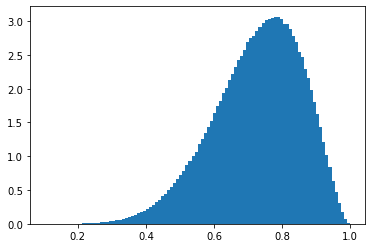

In [100]:
x = sample.detach().numpy()
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 100, density=True)
fig.canvas.draw()
plt.show()

In [101]:
probs = theta_weather.sample() # for instance the probability of being nice weither this year.
# A beta is used because the probability of weather being nice is different each year.
# alpha and beta could for instance be decided by location. i.e. some locations have nicer weahter,
# sample from beta will then be higher.
weather = dist.Bernoulli(probs=probs) # now we use the beta probability to make a bernoulli
torch.mean(weather.sample((365,))) # 365 days in a year, each number is the weather that day
# a sample of a year


tensor(0.8904)

## Beta as conjugate prior to bernoulli

In [102]:
# This is our truth model. We don't know this, 
# because we can never know the true model.
# We just observe the world (data) and update
# approximations
weather_true = dist.Bernoulli(probs=0.7)

In [103]:
N = 10
dataset = weather_true.sample((N,))
dataset

tensor([1., 1., 0., 1., 1., 0., 1., 0., 0., 0.])

In [104]:
# these values have highest prob at 0.7
alpha = 2.0
beta = 1.5 
alpha_prime = alpha + torch.sum(dataset)
beta_prime = beta + N - torch.sum(dataset)

In [105]:
alpha_prime

tensor(7.)

In [106]:
beta_prime

tensor(6.5000)

In [107]:
theta_weather = dist.Beta(alpha_prime, beta_prime)
sample = theta_weather.sample((1000000,))

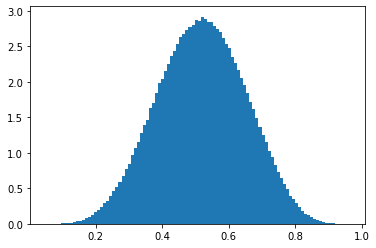

In [108]:
x = sample.detach().numpy()
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 100, density=True)
fig.canvas.draw()
plt.show()

# MAP for bernoulli

In [109]:
# set theta, which in reality we dont know
theta_weather_true = 0.8

weather = dist.Bernoulli(probs=0.8)
dataset = weather.sample((100,))
dataset = dataset.detach().numpy()
theta_weather_mle = dataset.mean()
theta_weather_mle

0.73

As you can see, the MLE is off. This is due to the MLE being bound to the dataset.  
With MAP we use 2 more parameters, alpha and beta.  
Alpha and beta encode prior knowledge, this can for instance be influence on the location where we measure the weather.

$$
\theta^*_{\text{MAP}} = \frac{\sum(w_i + \alpha - 1)}{N + \alpha \beta -2}
$$

In [110]:
alpha = 30
beta = 10
# narrow estimate because high numbers

In [111]:
theta_weather_map = (dataset.sum() + alpha - 1.0)/(len(dataset) + alpha + beta - 2.0) 
theta_weather_map

0.7391304347826086

As you can see the MAP is closer to the theta_weather_true, because we also encode prior knowledge.
To show this even better, let's use noise data

In [112]:
dataset[:50] = 0


In [113]:
theta_weather_mle_corrupt = dataset.mean()
theta_weather_mle_corrupt

0.37

In [114]:
theta_weather_map_corrupt = (dataset.sum() + alpha - 1.0)/(len(dataset) + alpha + beta - 2.0) 
theta_weather_map_corrupt

0.4782608695652174

As we can see, MLE is further away than MAP.